# Práctica 2
<h4>José María Ramírez González<h4>
<h5>Grado en Ingeniería Informática curso 2021-2022<h5>

---

## Introducción

En la siguiente línea de código, podemos ver las librerías que vamos a usar para el desarrollo de la práctica:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cmath import sqrt, log, e
from prettytable import PrettyTable
#https://stackoverflow.com/questions/55746749/latex-equations-do-not-render-in-google-colaboratory-when-using-matplotlib
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-sil-gentiumplus fonts-sil-gentiumplus-compact
  fonts-stix fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcups

*NumPy* lo usaremos para el manejo y modificación de los datos.

*Matplotlib* nos ayudará a mostrar gráficos para visualizar información relevante durante el desarrollo de la práctica.

*Cmath* nos proporcionará funciones matemáticas necesarias.

*PrettyTable* lo usaremos para mostrar las tablas que se nos pidan

Instalaremos LaTex en la MV para poder usarlo con *matplotlib* en los títulos.

## Problemas a explorar durante la práctica

El desarrollo de la práctica consistirá en **dos** ejercicios:


*   Cómo dificulta el ruido la elección del tipo de función de clasificación a usar (ejercicio 1).
*   Modelos lineales (ejercicio 2).

A su vez, ambos ejercicios estarán subdivididos en varios apartados que comentaremos en las secciones referentes a los mismos.


Antes de comenzar con la definición concreta y el estudio de los problemas, vamos a introducir unas funciones que usaremos durante el desarrollo de la práctica que nos han sido proporcionadas en el material de la misma.

In [4]:
def simula_unif(N, dim, rango):
	return np.random.uniform(rango[0],rango[1],(N,dim))

La función *simula_unif* nos proporciona una matriz de $N$ datos aleatorios uniformemente distribuidos en el rango $[-rango[0],rango[1]]×[-rango[0],rango[1]]$ con tantas dimensiones como indique $dim$.

In [2]:
def simula_gauss(N, dim, sigma):
    media = 0    
    out = np.zeros((N,dim),np.float64)        
    for i in range(N):
        # Para cada columna dim se emplea un sigma determinado. Es decir, para 
        # la primera columna (eje X) se usará una N(0,sqrt(sigma[0])) 
        # y para la segunda (eje Y) N(0,sqrt(sigma[1]))
        out[i,:] = np.random.normal(loc=media, scale=np.sqrt(sigma), size=dim)
    
    return out

Similar a la anterior, sólo que en este caso, nos proporciona los datos distribuidos en una distribución normal, cuya media es 0 y varianza es $sigma$.

In [3]:
def simula_recta(intervalo):
    points = np.random.uniform(intervalo[0], intervalo[1], size=(2, 2))
    x1 = points[0,0]
    x2 = points[1,0]
    y1 = points[0,1]
    y2 = points[1,1]
    # y = a*x + b
    a = (y2-y1)/(x2-x1) # Calculo de la pendiente.
    b = y1 - a*x1       # Calculo del termino independiente.
    
    return a, b

La función *simula_recta* nos proporciona de forma aleatoria los parámetros $a,b$ de una recta (cuya expresión es $y = ax + b$) en el rango dado por $[-intervalo[0],intervalo[1]]$

# Ejercicio 1

Este ejercicio trata sobre el **ruido y la elección de etiquetas**.

Tendremos varios apartados dentro del ejercicio:
1. Prueba de las funciones *simula_unif* y *simula_gauss*.
2. Introducción de ruido en las muestras y clasificación con varias funciones:
  1. Mostrar los puntos una vez hayamos asignado la etiqueta.
  2. Introducir el ruido y volver a mostrar.
  3. Usar distintas funciones y ver cómo ajustan con el ruido.

Entraremos más en detalle acerca del contenido de cada apartado en los mismos, que denominaremos $1.x$, siendo $x$ el número que corresponda al subíndice.

---

## Ejercicio 1.1

En este apartado se nos pide que dibujemos varias gráficas con las nubes de puntos correspondientes a las funciones *simula_unif* y *simula_gauss*.

No tiene mayor complicación, podemos ver el resultado y código correspondiente en la siguiente celda.

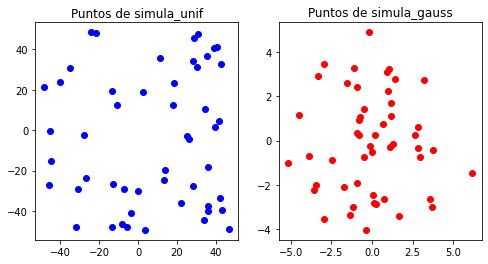

In [5]:

x_unif = simula_unif(50, 2, [-50,50])       # Obtenemos los puntos para ambos
x_gauss = simula_gauss(50, 2, np.array([5,7]))

fig = plt.figure(figsize=plt.figaspect(0.5))  # Creamos una figura en la que vamos a dibujar ambas subfiguras

ax = fig.add_subplot(1, 2, 1, title="Puntos de simula_unif")  # Subfigura de simula_unif
plt.scatter(x_unif[:,0], x_unif[:,1], c='blue')

ax = fig.add_subplot(1, 2, 2, title="Puntos de simula_gauss") # Subfigura de simula_gauss
plt.scatter(x_gauss[:,0], x_gauss[:,1], c='red')

plt.show()

A simple vista, parece que los puntos de *simula_gauss* están más concentrados que los de *simula_unif*, lo cual tiene sentido, puesto que al tratarse de una distribución normal, estarán más agrupados, al contrario que con una distribución uniforme.

## Ejercicio 1.2

En este apartado, que a su vez consta de varias partes, se nos pide que asignemos una etiqueta a cada punto y valoremos la influencia del ruido a la hora de dificultar la elección de una función que separe los datos según las etiquetas.

Vamos a dividir este ejercicio en **tres** partes:

* Dibujar un gráfico en el que se observe cada punto, con un color según su etiqueta, y la recta que separa la selección.
* Insertar ruido en el 10% de puntos y volver a mostrar la gráfica anterior.
* Cambiar la recta por una serie de funciones y ver cúal de ellas nos proporciona un mejor ajuste.

Entraremos más en detalle acerca del contenido de cada apartado en los mismos, que denominaremos $1.2.x$, siendo $x$ el número que corresponda al subíndice.

### Ejercicio 1.2.1

Este primer apartado no tiene mayor complicación, tan sólo es declarar las funciones que vamos a usar para asignar la etiqueta ($f(x,y) = y - ax - b$) y generar una recta aleatoria que usaremos para separar los datos.

Podemos ver toda la implementación en la siguiente celda de código.

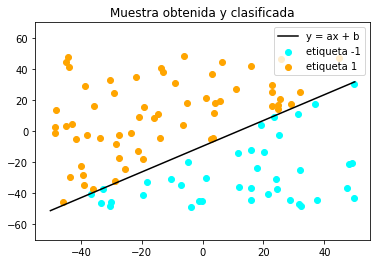

In [6]:
# La funcion np.sign(0) da 0, lo que nos puede dar problemas
def signo(x):
	if x >= 0:  # Signo positivo (o 0), devolvemos 1
		return 1
	return -1   # Signo negativo, devolvemos -1

def f(x, y, a, b):
	return signo(y - a*x - b)
 
a,b = simula_recta([-50,50])  # Simulamos una recta

x_line = np.linspace(-50,50,50) # Creamos una muestra de puntos para dibujar la recta

y_line = a*x_line + b           # Creamos nuestras 'y' para dibujar la recta

x_unif = simula_unif(100,2,[-50,50])  # Usamos simula unif

f = np.vectorize(f)       # Vectorizamos la función para usarla cómodamente con un array
y_unif_ordered = f(x_unif[:,0],x_unif[:,1], a, b)   # Asignamos las etiquetas

plt.ylim([-70,70])  # Establecemos un límite de altura para la gráfica y usamos np.where para filtrar por etiqueta a la hora de dibujar

plt.scatter(x_unif[np.where(y_unif_ordered == -1), 0], x_unif[np.where(y_unif_ordered == -1),1], c='cyan', label="etiqueta -1")
plt.scatter(x_unif[np.where(y_unif_ordered == 1), 0], x_unif[np.where(y_unif_ordered == 1),1], c='orange', label="etiqueta 1")

plt.plot(x_line, y_line, c='black', label="y = ax + b") # Pintamos la línea que hemos usado para clasificar
plt.title("Muestra obtenida y clasificada")
plt.legend()
plt.show()  # Mostramos la gráfica

Como vemos, la línea separa perfectamente los elementos.

### Ejercicio 1.2.2

Ahora bien, vamos a introducir ruido en la muestra y volver a mostrar la gráfica.

Se puede ver el código y el resultado en la siguiente celda. 

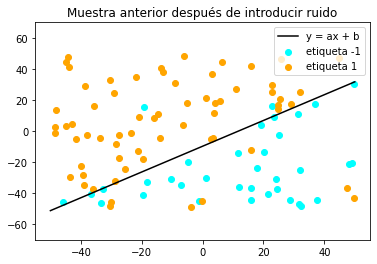

In [7]:
y_unif_unordered = y_unif_ordered.copy()

indices = np.random.choice(len(y_unif_unordered), size=int(y_unif_unordered.size/10), replace=False) # Tomamos los índices a modificar

y_unif_unordered[indices] = -y_unif_unordered[indices] # Cambiamos el signo de los indices

plt.ylim([-70,70])  # Establecemos un límite de altura para la gráfica y usamos np.where para filtrar por etiqueta a la hora de dibujar

plt.scatter(x_unif[np.where(y_unif_unordered == -1), 0], x_unif[np.where(y_unif_unordered == -1),1], c='cyan', label="etiqueta -1")
plt.scatter(x_unif[np.where(y_unif_unordered == 1), 0], x_unif[np.where(y_unif_unordered == 1),1], c='orange', label="etiqueta 1")

plt.plot(x_line, y_line, c='black', label="y = ax + b") # Pintamos la línea que hemos usado para clasificar
plt.title("Muestra anterior después de introducir ruido")
plt.legend()
plt.show()  # Mostramos la gráfica

Como observamos, ahora la línea no separa correctamente a ambos grupos, debido a que hemos introducido ruido.

### Ejercicio 1.2.3

Esta es la parte más ilustrativa de todas en lo que al ejercicio 1 se refiere.

En este apartado vamos a graficar varias funciones en el lugar de la recta, pero con las etiquetas obtenidas en el apartado anterior, acto seguido, usaremos estas funciones para crear nuevas muestras y añadirles ruido, observando si, a pesar del ruido, la división no resulta tan mala como en la recta.

Estas funciones son:

* $f(x,y) = (x-10)^2 + (y-20)^2 -400$
* $f(x,y) = 0.5(x+10)^2 + (y-20)^2 -400$
* $f(x,y) = 0.5(x-10)^2 - (y+20)^2 -400$
* $f(x,y) = y -20x^2 -5x + 3$

En función de y, se expresarían, en el orden anterior, como sigue:

* $\displaystyle y = 20 ± \sqrt{-x^2 + 20x +300}$
* $\displaystyle y = 20 ± \sqrt{-\frac{x^2}{2} - 10x +350}$
* $\displaystyle y = -20 ± \frac{\sqrt{x^2 - 20x - 700}}{\sqrt{2}}$
* $\displaystyle y = 20x^2 + 5x -3$

Ahora bien, vamos a proceder a la implementación de todo esto, teniendo en cuenta que para las gráficas cuya ecuación contenga un $±$, tendremos dos líneas en la gráfica, cada una de un color e indicado con el símbolo $+$ o $-$ según corresponda.

Lo primero, es definir las funciones anteriores en la siguiente línea de código.

In [8]:
first_func_plus = np.vectorize(lambda x : 20 + sqrt(-x**2 + 20*x + 300))
first_func_minus = np.vectorize(lambda x : 20 - sqrt(-x**2 + 20*x + 300))

second_func_plus = np.vectorize(lambda x : 20 + sqrt(-(x**2)/2 - 10*x + 350))
second_func_minus = np.vectorize(lambda x : 20 - sqrt(-(x**2)/2 - 10*x + 350))

third_func_plus = np.vectorize(lambda x : -20 + sqrt(x**2 - 20*x -700)/sqrt(2))
third_func_minus = np.vectorize(lambda x : -20 - sqrt(x**2 - 20*x -700)/sqrt(2))

fourth_func = np.vectorize(lambda x : 20*(x**2) + 5*x - 3)

Ahora, una vez definidas las funciones, podemos obtener una muestra de puntos usando la variable *x_line* que declaramos anteriormente.

In [9]:
first_line_plus = first_func_plus(x_line)
first_line_minus = first_func_minus(x_line)

second_line_plus = second_func_plus(x_line)
second_line_minus = second_func_minus(x_line)

third_line_plus = third_func_plus(x_line)
third_line_minus = third_func_minus(x_line)

fourth_x = np.linspace(-5,5,50)   # Creamos una muestra nueva para apreciar correctamente la función, debido al alto componente exponencial de la misma
fourth_line = fourth_func(fourth_x)

Una vez tengamos los valores, podemos pasar a dibujar las gráficas.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex

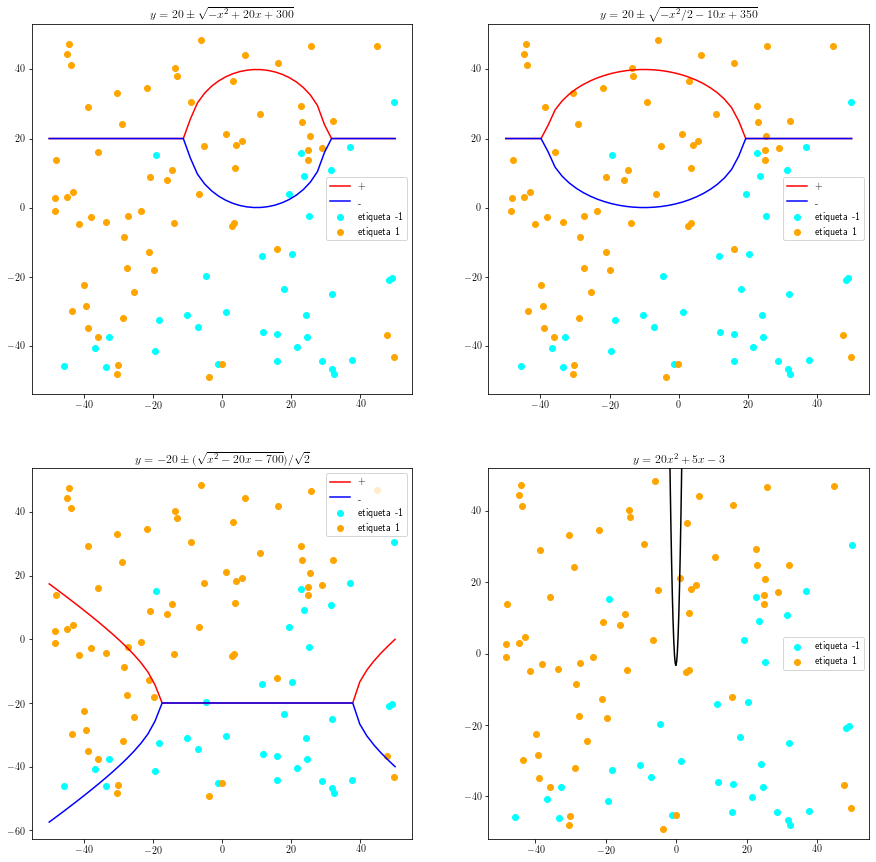

In [10]:
plt.rc('text', usetex=True)


# Para mostrar de esta forma las gráficas hemos tenido las siguientes fuentes:
# https://www.geeksforgeeks.org/plot-multiple-plots-in-matplotlib/
# https://datascienceparichay.com/article/change-figure-size-matplotlib/

fig, ax = plt.subplots(2,2, figsize=(15,15))    # Cambiamos el tamaño de la figura para que podamos apreciarlas con el detalle suficiente


######################################### Primera ecuación ##############################################
ax[0,0].scatter(x_unif[np.where(y_unif_unordered == -1), 0], x_unif[np.where(y_unif_unordered == -1),1], c='cyan', label="etiqueta -1")
ax[0,0].scatter(x_unif[np.where(y_unif_unordered == 1), 0], x_unif[np.where(y_unif_unordered == 1),1], c='orange', label="etiqueta 1")

ax[0,0].plot(x_line, first_line_plus, c='red', label="+") # Graficamos con el +
ax[0,0].plot(x_line, first_line_minus, c='blue', label="-") # Graficamos con el -
ax[0,0].set_title("$ y = 20 \pm \sqrt{-x^2 + 20x +300}$")
ax[0,0].legend()



######################################### Segunda ecuación ##############################################
ax[0,1].scatter(x_unif[np.where(y_unif_unordered == -1), 0], x_unif[np.where(y_unif_unordered == -1),1], c='cyan', label="etiqueta -1")
ax[0,1].scatter(x_unif[np.where(y_unif_unordered == 1), 0], x_unif[np.where(y_unif_unordered == 1),1], c='orange', label="etiqueta 1")

ax[0,1].plot(x_line, second_line_plus, c='red', label="+") # Graficamos con el +
ax[0,1].plot(x_line, second_line_minus, c='blue', label="-") # Graficamos con el -
ax[0,1].set_title("$ y = 20 \pm \sqrt{- x^2/2 - 10x + 350}$")
ax[0,1].legend()



######################################### Tercera ecuación ##############################################
ax[1,0].scatter(x_unif[np.where(y_unif_unordered == -1), 0], x_unif[np.where(y_unif_unordered == -1),1], c='cyan', label="etiqueta -1")
ax[1,0].scatter(x_unif[np.where(y_unif_unordered == 1), 0], x_unif[np.where(y_unif_unordered == 1),1], c='orange', label="etiqueta 1")

ax[1,0].plot(x_line, third_line_plus, c='red', label="+") # Graficamos con el +
ax[1,0].plot(x_line, third_line_minus, c='blue', label="-") # Graficamos con el -
ax[1,0].set_title("$ y = -20 \pm (\sqrt{x^2 - 20x - 700})/\sqrt{2}$")
ax[1,0].legend()


######################################### Cuarta ecuación ##############################################
ax[1,1].set_ylim(-52,52)  # Le ponemos límite al eje y debido al rápido crecimiento de la función
ax[1,1].scatter(x_unif[np.where(y_unif_unordered == -1), 0], x_unif[np.where(y_unif_unordered == -1),1], c='cyan', label="etiqueta -1")
ax[1,1].scatter(x_unif[np.where(y_unif_unordered == 1), 0], x_unif[np.where(y_unif_unordered == 1),1], c='orange', label="etiqueta 1")

ax[1,1].plot(fourth_x, fourth_line, c='black') # Graficamos la 4a ecuación
ax[1,1].set_title("$ y = 20x^2 + 5x -3$")
ax[1,1].legend()


plt.show()  # Mostramos la gráfica

Bueno, como podemos ver, las tres primeras funciones tienen una componente compleja en alguna de sus partes, no obstante, esto queda representado como una recta horizontal en la gráfica, ya que la parte real se mantiene igual.

Al haber usado una función completamente diferente a esta para clasificar los datos, es esperable el resultado obtenido: ninguna clasificación resulta tan siquiera minimamente acertada.

Vamos a usar la misma muestra de puntos para asignar etiquetas nuevas con estas funciones, observando el resultado obtenido y comprobando a ver si, al introducir ruido, mejoramos los resultados que obtuvimos con la recta.

Lo primero es definir las funciones que realizaran esta tarea, como vemos en la siguiente celda de código.

In [11]:
first_etiquette_func = np.vectorize(lambda x,y : signo((x-10)**2 + (y-20)**2 - 400))

second_etiquette_func = np.vectorize(lambda x,y : signo(0.5*((x+10)**2) + (y-20)**2 - 400))

third_etiquette_func = np.vectorize(lambda x,y : signo(0.5*((x-10)**2) - (y+20)**2 - 400))

fourth_etiquette_func = np.vectorize(lambda x,y : signo(y - 20*(x**2) - 5*x + 3))

Una vez definidas las funciones, generaremos etiquetas nuevas para la muestra de puntos *x_unif*.

In [12]:
first_et = first_etiquette_func(x_unif[:,0],x_unif[:,1])

second_et = second_etiquette_func(x_unif[:,0],x_unif[:,1])

third_et = third_etiquette_func(x_unif[:,0],x_unif[:,1])

fourth_et = fourth_etiquette_func(x_unif[:,0],x_unif[:,1])

Vamos a visualizar cómo quedaría la división por etiquetas con cada función antes de introducir el ruido a ver cómo ajustan.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex

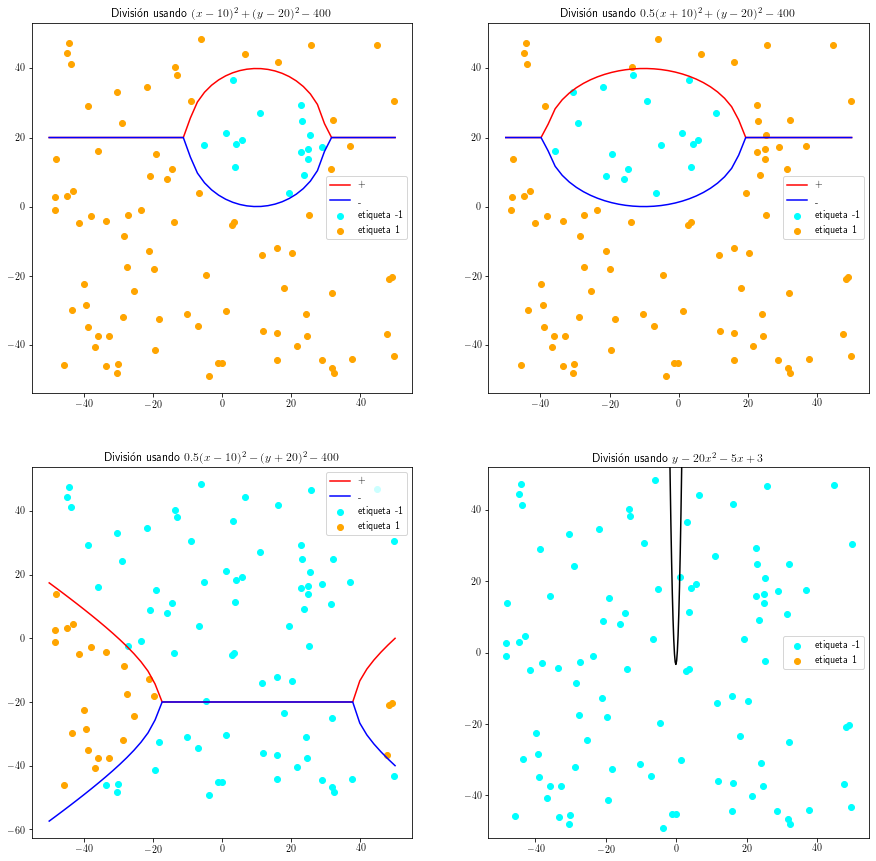

In [13]:
plt.rc('text', usetex=True)


# Para mostrar de esta forma las gráficas hemos tenido las siguientes fuentes:
# https://www.geeksforgeeks.org/plot-multiple-plots-in-matplotlib/
# https://datascienceparichay.com/article/change-figure-size-matplotlib/

fig, ax = plt.subplots(2,2, figsize=(15,15))    # Cambiamos el tamaño de la figura para que podamos apreciarlas con el detalle suficiente


######################################### Primera ecuación ##############################################
ax[0,0].scatter(x_unif[np.where(first_et == -1), 0], x_unif[np.where(first_et == -1),1], c='cyan', label="etiqueta -1")
ax[0,0].scatter(x_unif[np.where(first_et == 1), 0], x_unif[np.where(first_et == 1),1], c='orange', label="etiqueta 1")

ax[0,0].plot(x_line, first_line_plus, c='red', label="+") # Graficamos con el +
ax[0,0].plot(x_line, first_line_minus, c='blue', label="-") # Graficamos con el -
ax[0,0].set_title("División usando $(x-10)^2 + (y-20)^2 -400$")
ax[0,0].legend()



######################################### Segunda ecuación ##############################################
ax[0,1].scatter(x_unif[np.where(second_et == -1), 0], x_unif[np.where(second_et == -1),1], c='cyan', label="etiqueta -1")
ax[0,1].scatter(x_unif[np.where(second_et == 1), 0], x_unif[np.where(second_et == 1),1], c='orange', label="etiqueta 1")

ax[0,1].plot(x_line, second_line_plus, c='red', label="+") # Graficamos con el +
ax[0,1].plot(x_line, second_line_minus, c='blue', label="-") # Graficamos con el -
ax[0,1].set_title("División usando $0.5(x+10)^2 + (y-20)^2 - 400$")
ax[0,1].legend()



######################################### Tercera ecuación ##############################################
ax[1,0].scatter(x_unif[np.where(third_et == -1), 0], x_unif[np.where(third_et == -1),1], c='cyan', label="etiqueta -1")
ax[1,0].scatter(x_unif[np.where(third_et == 1), 0], x_unif[np.where(third_et == 1),1], c='orange', label="etiqueta 1")

ax[1,0].plot(x_line, third_line_plus, c='red', label="+") # Graficamos con el +
ax[1,0].plot(x_line, third_line_minus, c='blue', label="-") # Graficamos con el -
ax[1,0].set_title("División usando $0.5(x-10)^2 - (y+20)^2 - 400$")
ax[1,0].legend()


######################################### Cuarta ecuación ##############################################
ax[1,1].set_ylim(-52,52)  # Le ponemos límite al eje y debido al rápido crecimiento de la función
ax[1,1].scatter(x_unif[np.where(fourth_et == -1), 0], x_unif[np.where(fourth_et == -1),1], c='cyan', label="etiqueta -1")
ax[1,1].scatter(x_unif[np.where(fourth_et == 1), 0], x_unif[np.where(fourth_et == 1),1], c='orange', label="etiqueta 1")

ax[1,1].plot(fourth_x, fourth_line, c='black') # Graficamos la 4a ecuación
ax[1,1].set_title("División usando $y - 20x^2 - 5x + 3$")
ax[1,1].legend()


plt.show()  # Mostramos la gráfica

Como vemos, las etiquetas tienen una distribución bastante peculiar en la primera y la segunda función, estando la división en la parte definida por los valores donde no hay componentes imaginarios, en cambio, en la tercera función ocurre lo mismo, pero con las etiquetas invertidas, es decir, donde tenemos componente imaginaria, tenemos un -1 en vez de un 1.

La cuarta función produce el efecto esperado, definiendo una frontera normal y corriente entre los datos.

Ahora, podemos introducir el ruido en las etiquetas, para lo que vamos a usar el mismo método visto en el apartado 1.2.2.

In [14]:
first_indices = np.random.choice(len(first_et), size=int(first_et.size/10), replace=False)
first_et[indices] = -first_et[indices]

second_indices = np.random.choice(len(second_et), size=int(second_et.size/10), replace=False)
second_et[indices] = -second_et[indices]

third_indices = np.random.choice(len(third_et), size=int(third_et.size/10), replace=False)
third_et[indices] = -third_et[indices]

fourth_indices = np.random.choice(len(fourth_et), size=int(fourth_et.size/10), replace=False)
fourth_et[indices] = -fourth_et[indices]

Una vez hemos introducido el ruido, vamos a ver las gráficas anteriores y comentar si se distingue algún beneficio según la función.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex

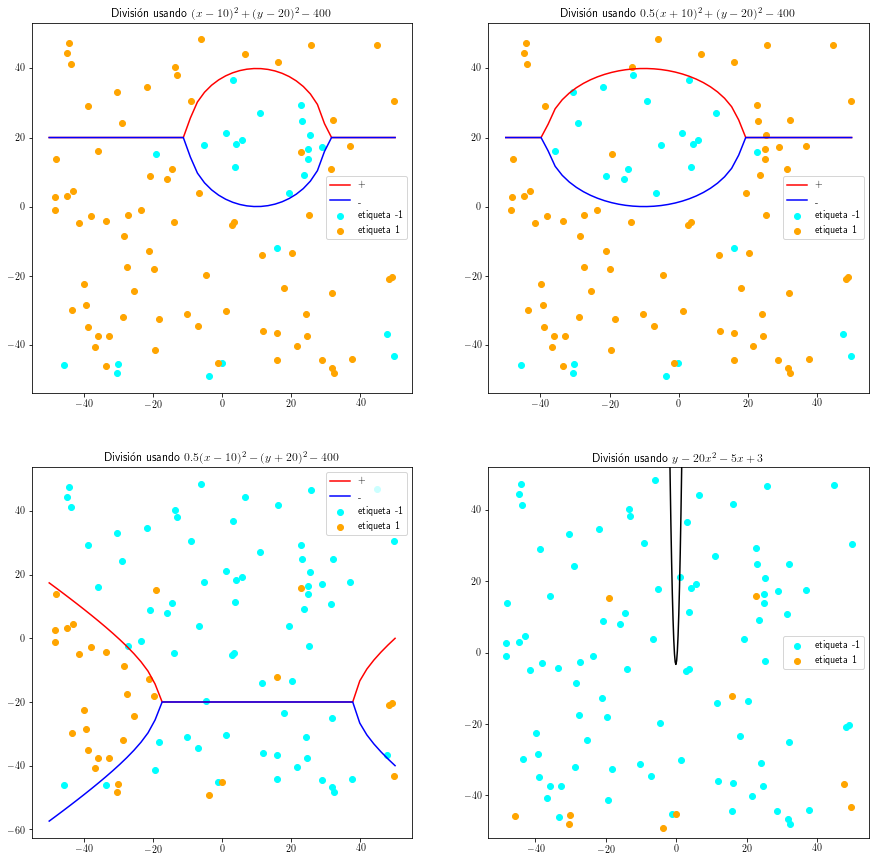

In [15]:
plt.rc('text', usetex=True)


# Para mostrar de esta forma las gráficas hemos tenido las siguientes fuentes:
# https://www.geeksforgeeks.org/plot-multiple-plots-in-matplotlib/
# https://datascienceparichay.com/article/change-figure-size-matplotlib/

fig, ax = plt.subplots(2,2, figsize=(15,15))    # Cambiamos el tamaño de la figura para que podamos apreciarlas con el detalle suficiente


######################################### Primera ecuación ##############################################
ax[0,0].scatter(x_unif[np.where(first_et == -1), 0], x_unif[np.where(first_et == -1),1], c='cyan', label="etiqueta -1")
ax[0,0].scatter(x_unif[np.where(first_et == 1), 0], x_unif[np.where(first_et == 1),1], c='orange', label="etiqueta 1")

ax[0,0].plot(x_line, first_line_plus, c='red', label="+") # Graficamos con el +
ax[0,0].plot(x_line, first_line_minus, c='blue', label="-") # Graficamos con el -
ax[0,0].set_title("División usando $(x-10)^2 + (y-20)^2 -400$")
ax[0,0].legend()



######################################### Segunda ecuación ##############################################
ax[0,1].scatter(x_unif[np.where(second_et == -1), 0], x_unif[np.where(second_et == -1),1], c='cyan', label="etiqueta -1")
ax[0,1].scatter(x_unif[np.where(second_et == 1), 0], x_unif[np.where(second_et == 1),1], c='orange', label="etiqueta 1")

ax[0,1].plot(x_line, second_line_plus, c='red', label="+") # Graficamos con el +
ax[0,1].plot(x_line, second_line_minus, c='blue', label="-") # Graficamos con el -
ax[0,1].set_title("División usando $0.5(x+10)^2 + (y-20)^2 - 400$")
ax[0,1].legend()



######################################### Tercera ecuación ##############################################
ax[1,0].scatter(x_unif[np.where(third_et == -1), 0], x_unif[np.where(third_et == -1),1], c='cyan', label="etiqueta -1")
ax[1,0].scatter(x_unif[np.where(third_et == 1), 0], x_unif[np.where(third_et == 1),1], c='orange', label="etiqueta 1")

ax[1,0].plot(x_line, third_line_plus, c='red', label="+") # Graficamos con el +
ax[1,0].plot(x_line, third_line_minus, c='blue', label="-") # Graficamos con el -
ax[1,0].set_title("División usando $0.5(x-10)^2 - (y+20)^2 - 400$")
ax[1,0].legend()


######################################### Cuarta ecuación ##############################################
ax[1,1].set_ylim(-52,52)  # Le ponemos límite al eje y debido al rápido crecimiento de la función
ax[1,1].scatter(x_unif[np.where(fourth_et == -1), 0], x_unif[np.where(fourth_et == -1),1], c='cyan', label="etiqueta -1")
ax[1,1].scatter(x_unif[np.where(fourth_et == 1), 0], x_unif[np.where(fourth_et == 1),1], c='orange', label="etiqueta 1")

ax[1,1].plot(fourth_x, fourth_line, c='black') # Graficamos la 4a ecuación
ax[1,1].set_title("División usando $y - 20x^2 - 5x + 3$")
ax[1,1].legend()


plt.show()  # Mostramos la gráfica

A la vista de estas nuevas gráficas, se podría decir que estas funciones parecen tener mayor "tolerancia" al ruido, ya que los valores que hemos "atrapado" en la frontera, se han visto casi sin afectar en todos los casos y, debido a que tenemos un mayor número de puntos fuera de nuestra frontera, el porcentaje de elementos mal clasificados para esa etiqueta concreta será menor, no obstante, hay que tener claro que tanto para la recta como para todas estas funciones tenemos el mismo número de elementos mal clasificados en todos los casos.

Lo que si es cierto, es que con estas últimas funciones no se aprecia tanto el ruido.

---

# Ejercicio 2

Este ejercicio trata sobre **modelos lineales**.

Consiste en implementar lo siguiente:

* Implementar el algoritmo Perceptrón (PLA).
* Implementar una Regresión Logística (RL).

Entraremos más en detalle acerca del contenido de cada apartado en los mismos, que denominaremos $2.x$, siendo $x$ el número que corresponda al subíndice.

---

## Ejercicio 2.1

En este ejercicio vamos a implementar el algoritmo Perceptrón (PLA), que calcula el hiperplano solución a un problema de clasificación binaria.

Vamos a usar los datos del ejercicio anterior para poner a prueba el algoritmo una vez lo implementemos.

En la siguiente celda de código podemos ver la implementación del algoritmo.

In [16]:
# Devuelve el Ein dado unos datos, pesos y etiquetas
def getEin(datos, weights, label):
  obtenido = 0
  for data, etiq in zip(datos, label):
    if (signo(weights.T @ data) != etiq): # Si no tienen el mismo signo, sumamos 1, es decir, sumamos un uno por cada fallo
      obtenido += 1
  obtenido /= len(datos)  # Calculamos la media
  return obtenido


# Vamos a usar lo que se conoce como el algoritmo "pocket" y no el PLA normal, ya que este tiene mejores resultados en la práctica
# para más información se puede consultar la siguiente web
# https://en.wikipedia.org/wiki/Perceptron#Variants
def ajusta_PLA_Pocket(datos, label, max_iter, vini):
    w = vini.copy() # Copiamos el array de pesos
    best_w = w.copy()
    ajusted = True
    curr_iter = 0
    while(ajusted and curr_iter < max_iter):  # Mientras no esté correctamente ajustado y no hayamos superado las máximas iteraciones
      ajusted = False
      for data, result in zip(datos,label):   # Recorremos nuestro conjunto de datos hasta encontrar un punto mal clasificado
        if (signo(w.T @ data) != result):
          curr_iter+=1
          ajusted = True
          w += result*data  # Actualizamos w
          break
      
      if(getEin(datos, w, label) < getEin(datos, best_w, label)): # Si la w resulta ser la mejor hasta el momento, la guardamos
        best_w = w.copy()

    return best_w , curr_iter

Como vemos, estamos usando la variante "Pocket" del perceptrón, más adelante haremos una comparativa con la versión normal y hablaremos de sus diferencias en la práctica.

Esta variante lo único que cambia es que en vez de dar el último valor de $w$ obtenido, devuelve los mejores de los que se tiene constancia.

Ahora bien, vamos a usar los datos tanto del apartado $1.2.1$ como los del apartado $1.2.2$. Los del apartado $1.2.1$ son linealmente separables, mientras que los del apartado $1.2.2$, al tener ruido introducido, no los son.

In [21]:
new_data = np.array([[1, x[0], x[1]] for x in x_unif])  # Insertamos un 1 al principio de cada columna de nuestro conjunto de datos

all_zeros = np.zeros(len(new_data[0]))  # Creamos un np.array de 0s

all_random = np.random.random(len(new_data[0])) # Creamos un np.array con valores aleatorios en el rango [0.0,1.0)

zero_weights_ordered, zero_it_ordered = ajusta_PLA_Pocket(new_data, y_unif_ordered, 10000, all_zeros)

random_weights_ordered, random_it_ordered = ajusta_PLA_Pocket(new_data, y_unif_ordered, 10000, all_random)

print("-----------------Pesos a 0-----------------")
print("Iteraciones: {}".format(zero_it_ordered))
print("Ein obtenido: {}\n".format(getEin(new_data, zero_weights_ordered, y_unif_ordered)))

print("--------------Pesos aleatorios--------------")
print("Iteraciones: {}".format(random_it_ordered))
print("Ein obtenido: {}".format(getEin(new_data, random_weights_ordered, y_unif_ordered)))



-----------------Pesos a 0-----------------
Iteraciones: 2502
Ein obtenido: 0.0

--------------Pesos aleatorios--------------
Iteraciones: 2551
Ein obtenido: 0.0


Obtenemos una clasificación perfecta para los datos del apartado $1.2.1$, tanto con pesos aleatorios como inicializándolos a 0.

Ahora bien, vamos a ver para el apartado $1.2.2$.

In [22]:
zero_weights_unordered, zero_it_unordered = ajusta_PLA_Pocket(new_data, y_unif_unordered, 10000, all_zeros)

random_weights_unordered, random_it_unordered = ajusta_PLA_Pocket(new_data, y_unif_unordered, 10000, all_random)

print("-----------------Pesos a 0-----------------")
print("Iteraciones: {}".format(zero_it_unordered))
print("Ein obtenido: {}\n".format(getEin(new_data, zero_weights_unordered, y_unif_unordered)))

print("--------------Pesos aleatorios--------------")
print("Iteraciones: {}".format(random_it_unordered))
print("Ein obtenido: {}".format(getEin(new_data, random_weights_unordered, y_unif_unordered)))

-----------------Pesos a 0-----------------
Iteraciones: 10000
Ein obtenido: 0.12

--------------Pesos aleatorios--------------
Iteraciones: 10000
Ein obtenido: 0.12


Como es esperable, ya que es imposible obtener una clasificación perfecta de estos datos por un perceptrón, agotamos las iteraciones.

Vamos a ver las líneas definidas por los perceptrones en cada caso de pesos y etiquetas.

[]

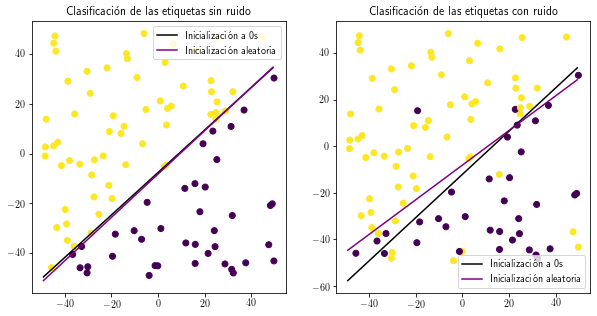

In [23]:
t_train = np.arange(np.amin(x_unif), np.amax(x_unif), 0.5)  # Muestreo de puntos para dibujar la recta a partir de los pesos

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].set_title("Clasificación de las etiquetas sin ruido")
ax[0].scatter(x_unif[:,0], x_unif[:,1], c=y_unif_ordered)
ax[0].plot(t_train, -zero_weights_ordered[0]/zero_weights_ordered[2]-zero_weights_ordered[1]/zero_weights_ordered[2]*t_train, 'black', label="Inicialización a 0s")
ax[0].plot(t_train, -random_weights_ordered[0]/random_weights_ordered[2]-random_weights_ordered[1]/random_weights_ordered[2]*t_train, 'purple', label="Inicialización aleatoria")
ax[0].legend()

ax[1].set_title("Clasificación de las etiquetas con ruido")
ax[1].scatter(x_unif[:,0], x_unif[:,1], c=y_unif_unordered)
ax[1].plot(t_train, -zero_weights_unordered[0]/zero_weights_unordered[2]-zero_weights_unordered[1]/zero_weights_unordered[2]*t_train, 'black', label="Inicialización a 0s")
ax[1].plot(t_train, -random_weights_unordered[0]/random_weights_unordered[2]-random_weights_unordered[1]/random_weights_unordered[2]*t_train, 'purple', label="Inicialización aleatoria")
ax[1].legend()

plt.plot()

En el caso de no tener ruido, la división obtenida es bastante similar, de hecho, si hablamos de la división que produce resulta ser la misma, por tanto podríamos ir un paso más alla y, a pesar de que sea ligeramente distinta, podríamos decir que, efectivamente, es la misma.

En el caso del ruido, depende en parte del punto inicial y del límite de iteraciones, puesto que, como hemos comentado anteriormente, se trata de un conjunto no linealmente separable y, por tanto, nunca alcanzará una separación perfecta.

Vamos ahora a realizar un pequeño estudio de cómo afectan los pesos aleatorios a nuestro objetivo, dividir correctamente todos los datos, para ello vamos a realizar 10 iteraciones con cada conjunto de datos, anotando los pesos inicialies aleatorios y las iteraciones que le lleva converger.

In [24]:
table = PrettyTable()

table.field_names = ["Peso inicial\Ruido", "No", "Si"]

for i in range(10):
  all_random = np.random.random(len(new_data[0])) # Creamos un np.array con valores aleatorios en el rango [0.0,1.0)
  print("Iteración {}, pesos iniciales: {}".format(i, all_random))
  random_weights_ordered, random_it_ordered = ajusta_PLA_Pocket(new_data, y_unif_ordered, 10000, all_random)
  random_weights_unordered, random_it_unordered = ajusta_PLA_Pocket(new_data, y_unif_unordered, 10000, all_random)

  table.add_row([all_random, str(random_it_ordered) + ", " + str(getEin(new_data, random_weights_ordered, y_unif_ordered)), str(random_it_unordered) + ", " + str(getEin(new_data, random_weights_unordered, y_unif_unordered))])
  print("--------------Etiquetas sin ruido--------------")
  print("Pesos obtenidos: {}".format(random_weights_ordered))

  print("--------------Etiquetas con ruido--------------")
  print("Pesos obtenidos: {}\n".format(random_weights_unordered))

print(table)

Iteración 0, pesos iniciales: [0.30797964 0.44182743 0.85182818]
--------------Etiquetas sin ruido--------------
Pesos obtenidos: [918.30797964 -86.20284678 105.14620822]
--------------Etiquetas con ruido--------------
Pesos obtenidos: [207.30797964 -23.05890498  26.51267275]

Iteración 1, pesos iniciales: [0.9328556  0.03079231 0.44712204]
--------------Etiquetas sin ruido--------------
Pesos obtenidos: [ 928.9328556  -102.5679519   120.54702999]
--------------Etiquetas con ruido--------------
Pesos obtenidos: [31.9328556  -2.34656624  3.00938352]

Iteración 2, pesos iniciales: [0.73398755 0.97760317 0.69374442]
--------------Etiquetas sin ruido--------------
Pesos obtenidos: [ 935.73398755 -103.30692309  121.45423816]
--------------Etiquetas con ruido--------------
Pesos obtenidos: [176.73398755 -18.7223396   18.33412713]

Iteración 3, pesos iniciales: [0.3757768  0.62240025 0.70134175]
--------------Etiquetas sin ruido--------------
Pesos obtenidos: [936.3757768  -89.77105896 108.79

Como vemos en la tabla (que podemos ver el número de iteraciones y el Ein), en lo que respecta al número de iteraciones (en los casos de no ruido), estas se encuentran en el rango (10-30), por lo que, de momento, podemos decir que los pesos inciales, efectivamente, afectan.

En cuanto al error obtenido (en el caso de ruido), se encuntra siempre en 0.1, pero esto se debe al gran número de iteraciones que hemos permitido, con lo cual, esta variación es efectivamente resultado de los pesos inciales.

Para ver los pesos finales, podemos fijarnos en el resto de la salida de la ejecución.

En resumen, podemos concluir que comenzar con unos pesos aleatorios puede afectar al rendimiento y a los resultados obtenidos, aumentando el número de iteraciones en el caso de converger y variando los resultados del error en el caso de las muestras no linealmente separables.

La diferencia principal entre aquellas muestras cuyas etiquetas tienen ruido y las que no es que, en el caso de estas últimas, llegamos a converger, encontrando un hiperplano que separe perfectamente la muestra, mientras que en las que tienen ruido, no. Esto explica porqué en la tabla en la muestra sin ruido sólo varían las iteraciones y en las que tienen ruido varía el error.

Vamos a ver ahora cómo sería un perceptrón sin "pocket", para comparar su funcionamiento con el ya implementado.

Podemos ver la implementación del perceptrón sin pocket y una pequeña modificación para guardar los Ein en la siguiente celda de código.

Sólo vamos a guardar los Ein, que es lo que nos resulta de interés para esta comparación.

In [65]:
# Igual a ajusta_PLA_pocket, pero sólo devuelve [Ein1, Ein2, ...., Einn]
def ajusta_PLA_Pocket_mod(datos, label, max_iter, vini):
    w = vini.copy() # Copiamos el array de pesos
    best_w = w.copy()
    ajusted = True
    curr_iter = 0
    all_Ein = []
    while(ajusted and curr_iter < max_iter):  # Mientras no esté correctamente ajustado y no hayamos superado las máximas iteraciones
      ajusted = False
      for data, result in zip(datos,label):   # Recorremos nuestro conjunto de datos hasta encontrar un punto mal clasificado
        if (signo(w.T @ data) != result):
          curr_iter+=1
          ajusted = True
          w += result*data  # Actualizamos w
          break
      
      if(getEin(datos, w, label) < getEin(datos, best_w, label)): # Si la w resulta ser la mejor hasta el momento, la guardamos
        best_w = w.copy()

      all_Ein.append(getEin(datos, best_w, label))

    return all_Ein


def ajusta_PLA(datos, label, max_iter, vini):
    w = vini.copy() # Copiamos el array de pesos
    all_Ein = []
    ajusted = True
    curr_iter = 0
    while(ajusted and curr_iter < max_iter):  # Mientras no esté correctamente ajustado y no hayamos superado las máximas iteraciones
      ajusted = False
      for data, result in zip(datos,label):   # Recorremos nuestro conjunto de datos hasta encontrar un punto mal clasificado
        if (signo(w.T @ data) != result):
          curr_iter+=1
          ajusted = True
          w += result*data  # Actualizamos w
          break

      all_Ein.append(getEin(datos, w, label))

    return w, curr_iter   # Devolvemos los pesos y el número de iteraciones

# Igual a ajusta_PLA, pero sólo devuelve [Ein1, Ein2, ...., Einn]
def ajusta_PLA_mod(datos, label, max_iter, vini):
    w = vini.copy() # Copiamos el array de pesos
    all_Ein = []
    ajusted = True
    curr_iter = 0
    while(ajusted and curr_iter < max_iter):  # Mientras no esté correctamente ajustado y no hayamos superado las máximas iteraciones
      ajusted = False
      for data, result in zip(datos,label):   # Recorremos nuestro conjunto de datos hasta encontrar un punto mal clasificado
        if (signo(w.T @ data) != result):
          curr_iter+=1
          ajusted = True
          w += result*data  # Actualizamos w
          break

      all_Ein.append(getEin(datos, w, label))

    return all_Ein

Para el motivo de esta comparativa, sólo vamos a usar las etiquetas con ruido, ya que queremos que llegue al máximo de iteraciones, y vamos a graficar los Ein.

[]

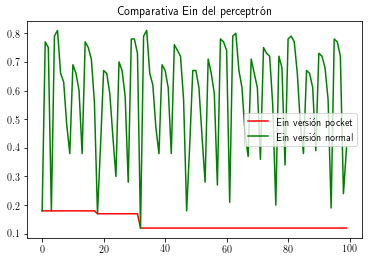

In [66]:
Ein_pocket = ajusta_PLA_Pocket_mod(new_data, y_unif_unordered, 100, all_zeros)

Ein_regular = ajusta_PLA_mod(new_data, y_unif_unordered, 100, all_zeros)

plt.plot(Ein_pocket, c='red', label="Ein versión pocket")
plt.plot(Ein_regular, c='green', label="Ein versión normal")
plt.legend()
plt.title("Comparativa Ein del perceptrón")
plt.plot()

Como vemos, la versión pocket se queda con la mejor versión de los pesos encontrados hasta el momento, mientras que la versión normal itera y devuelve el último obtenido, que no tiene por qué ser el mejor.

## Ejercicio 2.2

En este ejercicio vamos a implementar una regresión logística (RL) con el gradiente descendente estocástico, llegando al mismo resultado que en el apartado anterior, una clasificación binaria en nuestro espacio de muestreo.

En la siguiente celda de código podemos ver la implementación del algoritmo.

In [48]:
def crossEntropy(data, weights, labels):
  valor = 0
  for x, y in zip(data, labels):
    valor += log(1+e**(-y*(weights.T @ x)))

  valor/= len(data)
  return valor.real

# Gradiente Descendente Estocastico
# Fuentes: https://medium.com/@nikhilparmar9/simple-sgd-implementation-in-python-for-linear-regression-on-boston-housing-data-f63fcaaecfb1
# https://stackoverflow.com/questions/63518634/stochastic-gradient-descent-implementation-in-python-from-scratch-is-the-implem
def sgd(train_data, lr, y, epsilon, max_iter, batch_size, vini, divide_by):

    iterations_per_epoch = int(len(y)/batch_size)
    w = vini.copy()
    last_w = w.copy()
    iterations = 0

    delta_w = 1

    while delta_w > epsilon and iterations < max_iter:

        curr_index = 0
        last_w = w.copy()
        indices = np.random.permutation(len(y))
        train_data, y = train_data[indices], y[indices] # Permutamos, ya que hemos terminado una época

        for iteration in range(iterations_per_epoch):
          shuffled_train, shuffled_y = train_data[curr_index:curr_index+batch_size], y[curr_index:curr_index+batch_size]
          
          gradiente_w = 0
          
          for x, t in zip(shuffled_train, shuffled_y):
            gradiente_w += (t*x)/(1+e**(t*(w.T @ x)))
          
          gradiente_w /= batch_size
          gradiente_w = -gradiente_w.real

          w -= lr*gradiente_w # Actualizamos los pesos
          
          iterations+=1
          curr_index += batch_size
        
        lr /= divide_by

        delta_w = np.linalg.norm(w - last_w) # Calculamos el error de nuevo
          
    
    return w, iterations   # Tan solo devolvemos los pesos

Como vemos, es el gradiente descendente estocástico que usamos en la práctica anterior, pero esta vez el cálculo del error no se hace por error cuadrático medio, si no que se aplica un error de clasificación, definido anteriormente.

Además, está ligeramente modificado para contar las épocas, calcular la diferencia de los pesos entre épocas y actualizar el *learning rate*.

Vamos a generar una pequeña muestra aleatoria en el rango $[0,2] \times [0,2]$ y dividirla con una recta, también aleatoria.

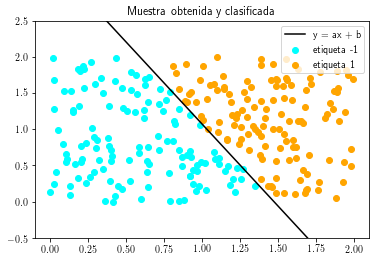

In [53]:
a,b = simula_recta([0,2])  # Simulamos una recta

x_line = np.linspace(0,2,50) # Creamos una muestra de puntos para dibujar la recta

y_line = a*x_line + b           # Creamos nuestras 'y' para dibujar la recta

x_unif = simula_unif(256,2,[0,2])  # Usamos simula unif

y_unif_ordered = f(x_unif[:,0],x_unif[:,1], a, b)   # Asignamos las etiquetas

plt.ylim([-0.5,2.5])  # Establecemos un límite de altura para la gráfica y usamos np.where para filtrar por etiqueta a la hora de dibujar

plt.scatter(x_unif[np.where(y_unif_ordered == -1), 0], x_unif[np.where(y_unif_ordered == -1),1], c='cyan', label="etiqueta -1")
plt.scatter(x_unif[np.where(y_unif_ordered == 1), 0], x_unif[np.where(y_unif_ordered == 1),1], c='orange', label="etiqueta 1")

plt.plot(x_line, y_line, c='black', label="y = ax + b") # Pintamos la línea que hemos usado para clasificar
plt.title("Muestra obtenida y clasificada")
plt.legend()
plt.show()  # Mostramos la gráfica

Vamos a encontrar el clasificador usando la regresión logística recién implementada, para ello, inciailizamos los pesos a 0, no sin antes añadir un $1$ a las etiquetas y llamamos al gradiente descendente estocástico.

Pesos obtenidos: [-15.77664824  11.05310015   4.45055809]
Iteraciones obtenidas: 1952
Ein obtenido: 0.08104281573419543


[]

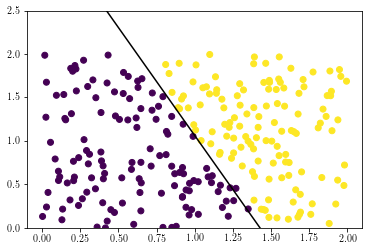

In [54]:
data_ready = np.array([[1, x[0], x[1]] for x in x_unif])

initial_weights = np.zeros(len(data_ready[0]))

result_weights, iterations = sgd(data_ready, 2, y_unif_ordered, 0.01, 2000, 32, initial_weights, 1.008)

print("Pesos obtenidos: {}".format(result_weights))
print("Iteraciones obtenidas: {}".format(iterations))
print("Ein obtenido: {}".format(crossEntropy(data_ready, result_weights, y_unif_ordered)))

plt.ylim([0,2.5])
t_train = np.arange(np.amin(x_unif), np.amax(x_unif), 0.05)
plt.scatter(x_unif[:,0], x_unif[:,1], c=y_unif_ordered)
plt.plot(t_train, -result_weights[0]/result_weights[2]-result_weights[1]/result_weights[2]*t_train, 'black', label="Inicialización a 0s")
plt.plot()

Como vemos, el ajuste es bastante decente y la velocidad de ejecución no es para nada mala, se puede apreciar que se cumple la condición al cabo de casi las 2000 iteraciones.

Vamos a generar una nueva muestra, clasificarla siguiendo la misma recta usada en la clasificación anterior y calcular el $Eout$.

Eout obtenido: 0.1191868895941415
Error de clasificación obtenido: 0.043


[]

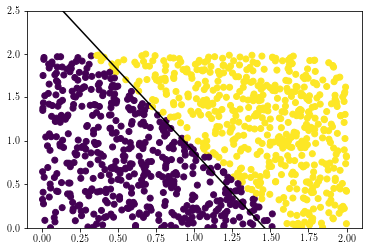

In [60]:
x_unif = simula_unif(1000,2,[0,2])  # Usamos simula unif

y_unif_ordered = f(x_unif[:,0],x_unif[:,1], a, b)   # Asignamos las etiquetas

data_ready = np.array([[1, x[0], x[1]] for x in x_unif])

print("Eout obtenido: {}".format(crossEntropy(data_ready, result_weights, y_unif_ordered)))
print("Error de clasificación obtenido: {}".format(getEin(data_ready, result_weights, y_unif_ordered)))

plt.ylim([0,2.5])
t_train = np.arange(np.amin(x_unif), np.amax(x_unif), 0.05)
plt.scatter(x_unif[:,0], x_unif[:,1], c=y_unif_ordered)
plt.plot(t_train, -result_weights[0]/result_weights[2]-result_weights[1]/result_weights[2]*t_train, 'black', label="Inicialización a 0s")
plt.plot()

Podemos observar que el error de clasificación obtenido es bastante bueno, por debajo de un **5%**, por lo que podemos concluir que, efectivamente, nuestra regresión logística funciona correctamente.

Ahora vamos a realizar lo que se nos pide:

* Generar una muestra de 100 puntos en el rango anterior.
* Generar una línea que los divida.
* Clasificar los puntos en función de esa línea.
* Ajustar usando la regresión logística.
* Generar una nueva muestra de +999 elementos.
* Calcular el $Eout$ para esta nueva muestra, la cual hemos clasificado en base a la línea anterior.

De este experimento, que repetiremos 100 veces, obtendremos una tabla con los valores de $Eout$, el porcentaje de error en la clasificación y épocas necesarias para converger de cada iteración. Además obtendremos los valores medios de los mismos.

In [73]:
mean_Eout = 0
mean_epochs = 0
mean_class_error = 0

n = 100

table = PrettyTable()

table.field_names = ["Iteración", "Eout", "Error de clasificación", "Épocas para converger"]

for iteration in range(n):
  a,b = simula_recta([0,2])  # Simulamos una recta

  x_unif = simula_unif(100,2,[0,2])  # Usamos simula unif

  y_unif_ordered = f(x_unif[:,0],x_unif[:,1], a, b)   # Asignamos las etiquetas

  data_ready = np.array([[1, x[0], x[1]] for x in x_unif])

  result_weights, iterations = sgd(data_ready, 2, y_unif_ordered, 0.01, 1000, 32, initial_weights, 1.008)

  x_unif = simula_unif(5000,2,[0,2])  # Usamos simula unif

  y_unif_ordered = f(x_unif[:,0],x_unif[:,1], a, b)   # Asignamos las etiquetas

  data_ready = np.array([[1, x[0], x[1]] for x in x_unif])

  table.add_row([iteration, crossEntropy(data_ready, result_weights, y_unif_ordered), getEin(data_ready, result_weights, y_unif_ordered), iterations])

  mean_Eout += crossEntropy(data_ready, result_weights, y_unif_ordered)
  mean_epochs += int(len(y_unif_ordered)/32)
  mean_class_error += getEin(data_ready, result_weights, y_unif_ordered)




print(table)

mean_Eout /= n
mean_epochs /= n
mean_class_error /= n

print("Eout medio: {}".format(mean_Eout))
print("Épocas necesitadas medias: {}".format(mean_epochs))
print("Error de clasificación medio: {}".format(mean_class_error))

+-----------+---------------------+------------------------+-----------------------+
| Iteración |         Eout        | Error de clasificación | Épocas para converger |
+-----------+---------------------+------------------------+-----------------------+
|     0     | 0.08574375777492103 |         0.007          |          543          |
|     1     | 0.10800741101757462 |         0.013          |          615          |
|     2     | 0.12096736293848259 |         0.0182         |          603          |
|     3     | 0.12530775827289503 |         0.0182         |          615          |
|     4     | 0.10461840450348743 |         0.0318         |          594          |
|     5     |  0.1327597483370183 |         0.0186         |          615          |
|     6     | 0.09394019379763409 |         0.024          |          630          |
|     7     |  0.095238319286597  |         0.0398         |          471          |
|     8     | 0.09043460731409061 |         0.013          |     

Como vemos, obtenemos un error de clasificación medio inferior al **3%**, un $Eout$ medio de 0.1 y necesitamos alrededor de 150 épocas para converger de media.

Estos resultados son bastante buenos, de hecho, para afirmar con seguridad la idoneidad de las soluciondes de este algoritmo, vamos a compararlo con el perceptrón (versión normal), sometiendo a este último al mismo experimento.

Como no podemos calcular el $Eout$ de forma justa, vamos a comparar sólo número de iteraciones y error de clasificación.

In [74]:
mean_epochs = 0
mean_class_error = 0

n = 100

table = PrettyTable()

table.field_names = ["Iteración", "Error de clasificación", "Épocas para converger"]

for iteration in range(n):
  a,b = simula_recta([0,2])  # Simulamos una recta

  x_unif = simula_unif(100,2,[0,2])  # Usamos simula unif

  y_unif_ordered = f(x_unif[:,0],x_unif[:,1], a, b)   # Asignamos las etiquetas

  data_ready = np.array([[1, x[0], x[1]] for x in x_unif])

  result_weights, iterations = ajusta_PLA(data_ready, y_unif_ordered, 2000, initial_weights)

  x_unif = simula_unif(5000,2,[0,2])  # Usamos simula unif

  y_unif_ordered = f(x_unif[:,0],x_unif[:,1], a, b)   # Asignamos las etiquetas

  data_ready = np.array([[1, x[0], x[1]] for x in x_unif])

  table.add_row([iteration, getEin(data_ready, result_weights, y_unif_ordered), iterations])

  mean_epochs += iterations
  mean_class_error += getEin(data_ready, result_weights, y_unif_ordered)




print(table)

mean_epochs /= n
mean_class_error /= n

print("Iteraciones medias: {}".format(mean_epochs))
print("Error de clasificación medio: {}".format(mean_class_error))

+-----------+------------------------+-----------------------+
| Iteración | Error de clasificación | Épocas para converger |
+-----------+------------------------+-----------------------+
|     0     |         0.027          |           60          |
|     1     |         0.0086         |           33          |
|     2     |         0.071          |          171          |
|     3     |         0.0134         |          143          |
|     4     |         0.0092         |          620          |
|     5     |         0.0122         |          234          |
|     6     |         0.005          |          1436         |
|     7     |         0.0108         |          346          |
|     8     |         0.0086         |          2000         |
|     9     |         0.0352         |          2000         |
|     10    |         0.0036         |          257          |
|     11    |         0.0322         |           93          |
|     12    |         0.0782         |          2000   

Como vemos, el error de clasificación obtenido es bastante similar, pero lo cierto es que, en la práctica, con un número de datos suficiente, por normal general suele obtener mejores resultados la regresión logística.
Es cierto que también conlleva una mayor dificultad, ya que tiene más parámetros a modificar, por lo cual requiere de bastante prueba y error para obtener buenos resultados.

# Conclusión

En el desarrollo de esta práctica, hemos explorado la capacidad de los modelos lineales para técnicas de clasificación, concretamente, el perceptrón y la regresión logística implementada con el gradiente descendente estocástico.

Además un factor que no hemos comentado en la práctica, ha sido la capacidad de expandir esta linealidad para aprender de forma no lineal, es decir, modificando el vector de características para obtener características no lineales, podemos clasificar usando métodos lineales. Estas formas de clasificación se siguen llamando lineales debido a que la linealidad reside en los pesos, $w$, independientemente de las características.

En lo que respecta a los protagonistas de esta práctica, el perceptrón y la regresión logística, hay que destacar la vital importancia de estos que, pese a ser dos algoritmos muy sencillo, resultaron ser un pilar fundamental que sentó las bases de los distintos métodos de clasificación usando aprendizaje automático y siguen, a día de hoy, siendo usados en un gran número de casos reales ya que presentan muy buenos resultados.